In [87]:
from copy import copy
%matplotlib inline
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit.circuit.library import U3Gate, U2Gate, U1Gate, CXGate, SwapGate
from qiskit.test.mock import FakeParis

from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler import Layout, CouplingMap
#from qiskit.transpiler.passes import SabreSwap, BasicSwap, SabreLayout
from qiskit import transpile

#from qiskit import IBMQ
from qiskit import Aer, execute
from qiskit.providers.aer import noise
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise.errors import standard_errors as SE
from qiskit.providers.aer.noise.device import models
import pickle
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

## Question 1

#### First, we decompose our benchmarked circuits to be IBM compliant (adapted from the provided example)

In [96]:
def get_benchmark_dict(path):
    import glob
    list_qasm = glob.glob(path+'/*.qasm')
    circuit_dict = {}
    for qasm_file in list_qasm:
        circuit_name = qasm_file.split('.qasm')[0].split('Benchmarks/')[1]
        circuit = QuantumCircuit.from_qasm_file(qasm_file)
        circuit.name = circuit_name
        circuit_dict[circuit_name] = circuit
    return circuit_dict

def decompose_benchmarks(benchmark_dict):
    new_dict = {}
    for circuit_name, circuit in benchmark_dict.items():
        new_dict[circuit_name] = transpile(circuit, basis_gates=['cx','u1','u2','u3'])
    return new_dict

def benchmark(benchmark_dict):
    for qc_name, qc in benchmark_dict.items():
        cx_count = 0
        u1_count = 0
        u2_count = 0
        u3_count = 0
        for gate in qc.data:
            if isinstance(gate[0], CXGate):
                cx_count += 1
            elif isinstance(gate[0], U1Gate):
                u1_count += 1
            elif isinstance(gate[0], U2Gate):
                u2_count += 1
            elif isinstance(gate[0], U3Gate):
                u3_count += 1
        print(qc_name)
        print('CXGates: ' + str(cx_count))
        print('U1Gates: ' + str(u1_count))
        print('U2Gates: ' + str(u2_count))
        print('U3Gates: ' + str(u3_count))
        print('Total Gates: ' + str(qc.size()))
        print('Depth: ' + str(qc.depth()))
        print('----------')

def get_swaps(circuit):
    swap_gates = 0
    for gate in circuit.data:
        if isinstance(gate[0], SwapGate):
            swap_gates += 1
    return swap_gates

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

def plot_circuit(circuit_name, map_names, swaps, label1, label2, depths=None):
    import numpy as np
    import matplotlib.pyplot as plt
    x = np.arange(len(map_names))  # the label locations
    width = 0.35  # the width of the bars
    fig, ax = plt.subplots()
    plt.grid(True)
    rects1 = ax.bar(x - width/2, swaps, width, label=label1)
    if depths:
        rects2 = ax.bar(x + width/2, depths, width, label=label2)
    ax.set_ylabel('Quantity')
    ax.set_title(circuit_name)
    ax.set_xticks(x)
    ax.set_xticklabels(map_names)
    ax.legend()
    #autolabel(rects1)
    #autolabel(rects2)
    fig.tight_layout()
    
def plot_model(model_dict, depth_dict=None, label1=None, label2=None):
    map_names = ['Grid 5x5','Grid 5x4','Grid 7x3','Ring 20','Paris']
    for qc_name in model_dict:
        swap_dict = model_dict[qc_name]
        swaps = []
        depths = []
        for map_name in swap_dict:
            swaps.append(swap_dict[map_name])
            if depth_dict:
                depths.append(depth_dict[qc_name][map_name])
        plot_circuit(qc_name, map_names, swaps, label1, label2, depths)
    
def create_coupling_maps():
    coupling_dict = {}
    coupling_dict['grid_5x5'] = CouplingMap.from_grid(5,5)
    coupling_dict['grid_5x4'] = CouplingMap.from_grid(5,4)
    coupling_dict['grid_7x3'] = CouplingMap.from_grid(7,3)
    coupling_dict['ring_20'] = CouplingMap.from_ring(20)
    coupling_dict['paris'] = CouplingMap(FakeParis().configuration().coupling_map)
    return coupling_dict

def execute_sabre(benchmark_dict, coupling_dict, iterations):
    sabre_model = {}
    map_names = ['Grid 5x5','Grid 5x4','Grid 7x3','Ring 20','Paris']
    for qc_name in benchmark_dict:
        qc = benchmark_dict[qc_name]
        swap_avgs = []
        depth_avgs = []
        map2swaps = {}
        for map_name in coupling_dict:
            coupling_map = coupling_dict[map_name]
            all_swaps = []
            all_depths = []
            old_num_gates = qc.num_nonlocal_gates()
            for _ in range(iterations):
                new_qc = transpile(qc, coupling_map=coupling_map, optimization_level=0, 
                                   routing_method='sabre', layout_method='sabre')
                all_swaps.append(get_swaps(new_qc))
                all_depths.append(new_qc.depth())
            swap_avgs.append(sum(all_swaps)/len(all_swaps))
            depth_avgs.append(sum(all_depths)/len(all_depths))
            map2swaps[map_name] = sum(all_swaps)/len(all_swaps)
            print(map_name+'   '+qc_name)
            print('swaps: '+str(sum(all_swaps)/len(all_swaps)))
            print('depths: '+str(sum(all_depths)/len(all_depths)))
            print('----------------')
        #plot_circuit(qc_name, map_names, swap_avgs, 'SWAPs Added', 'Depth', depth_avgs)
        sabre_model[qc_name] = map2swaps
    return sabre_model

def execute_ga(benchmark_dict, coupling_dict):
    # benchmark our own model
    map_names = ['Grid 5x5','Grid 5x4','Grid 7x3','Ring 20','Paris']
    ga_dict,_ = load_file('opt2_results.lookahead')
    my_model = {}
    print(ga_dict.keys())
    for qc_name, layout_dict in ga_dict.items():
        swaps = []
        depths = []
        map2swaps = {}
        for map_name in coupling_dict.keys():
            layout = layout_dict[map_name]
            qc = benchmark_dict[qc_name]
            coupling_map = coupling_dict[map_name]
            try:
                new_qc = transpile(qc, coupling_map=coupling_map, optimization_level=0, 
                                       routing_method='lookahead', initial_layout=layout)
            except:
                new_qc = transpile(qc, coupling_map=coupling_map, optimization_level=0, 
                                       routing_method='basic', initial_layout=layout)
            added_swaps = get_swaps(new_qc)
            swaps.append(added_swaps)
            depths.append(new_qc.depth())
            print(qc_name+'    '+map_name)
            print(new_qc.depth())
            print('-------')
            map2swaps[map_name] = added_swaps
        #plot_circuit(qc_name, map_names, swaps, 'SWAPs Added','Depth', depths)
        my_model[qc_name] = map2swaps
    return my_model

def load_file(filename, get_depth=False):
    ga_dict = {}
    depth_dict = {}
    f = open(filename,'r')
    for line in f:
        if ':' not in line:
            current_circuit = line.strip()
            ga_dict[current_circuit] = {}
            depth_dict[current_circuit] = {}
            continue
        data = line.split(':')
        data = [d.strip() for d in data]
        #layout = data[1].strip().split()
        #layout = [int(s) for s in layout]
        #ga_dict[current_circuit][data[0]] = layout
        ga_dict[current_circuit][data[0]] = float(data[2])
        if get_depth:
            depth_dict[current_circuit][data[0]] = float(data[3])
    f.close()
    return ga_dict, depth_dict

#### Now put it all together: decompose our circuits and retrieve the benchmarks

In [97]:
# get our benchmark circuits (not decomposed)
benchmark_dict = get_benchmark_dict(path='./SWAP_Benchmarks')
# decompose our benchmark circuits
benchmark_dict = decompose_benchmarks(benchmark_dict)
# Initialize our coupling maps to be tested on
coupling_dict = create_coupling_maps()

benchmark(benchmark_dict)

QV9
CXGates: 24
U1Gates: 0
U2Gates: 8
U3Gates: 49
Total Gates: 90
Depth: 14
----------
QFT-6
CXGates: 19
U1Gates: 13
U2Gates: 3
U3Gates: 0
Total Gates: 41
Depth: 25
----------
BV-10
CXGates: 5
U1Gates: 0
U2Gates: 12
U3Gates: 0
Total Gates: 27
Depth: 8
----------
QFT-15
CXGates: 115
U1Gates: 151
U2Gates: 30
U3Gates: 3
Total Gates: 302
Depth: 224
----------
qft_n20
CXGates: 380
U1Gates: 570
U2Gates: 20
U3Gates: 0
Total Gates: 990
Depth: 150
----------
qaoa10_depth2
CXGates: 18
U1Gates: 0
U2Gates: 16
U3Gates: 30
Total Gates: 74
Depth: 24
----------
BV-15
CXGates: 14
U1Gates: 0
U2Gates: 28
U3Gates: 0
Total Gates: 57
Depth: 17
----------


## Question 2

#### First, we create our coupling maps to be tested with the benchmarks, then test each benchmark circuit with each coupling map. The results are compiled into a set of graphs for easy visualization. 
#### Note: run the code block below this one, this block takes a while to execute...

In [ ]:
# Run the next code block, results are stored in a file. This will take a while...
iterations = 10
sabre_model = execute_sabre(benchmark_dict, coupling_dict, iterations)

#### Since the code above can take some time to execute with SABRE, the results have been stored in a file. To get the same results, but faster, run this code block instead.

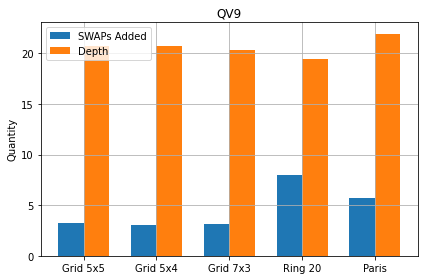

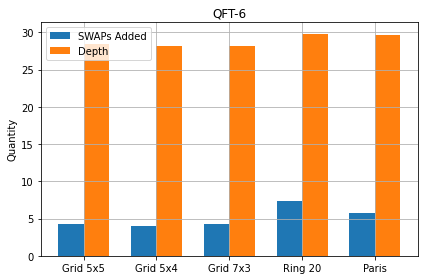

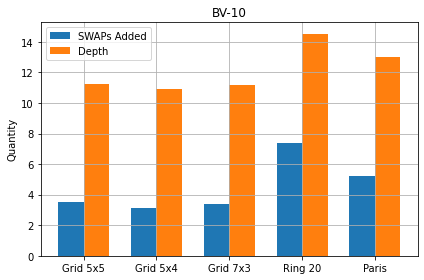

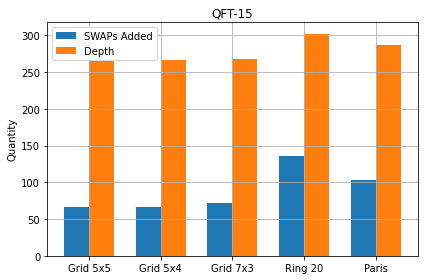

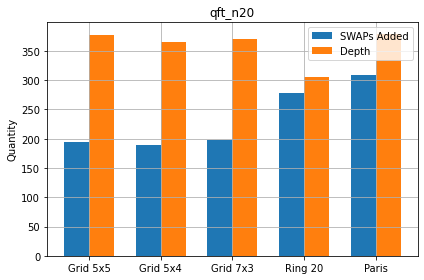

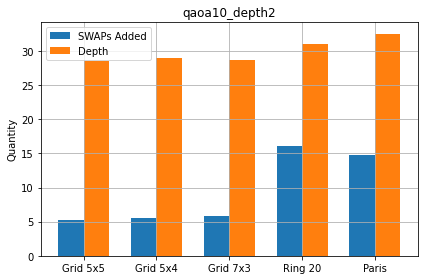

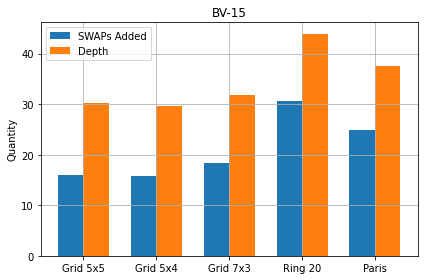

In [90]:
# Optimization level set to 0 to not interfere with SABRE 
sabre_model, depths = load_file('sabre_results', get_depth=True)
plot_model(sabre_model, depths, 'SWAPs Added', 'Depth')

## Question 3

#### Here, we benchmark our own model after the GA is done optimizing. The code for the GA is at the very end of this notebook, due to the length.

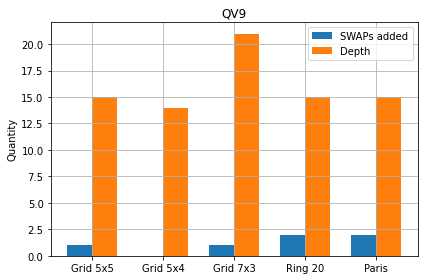

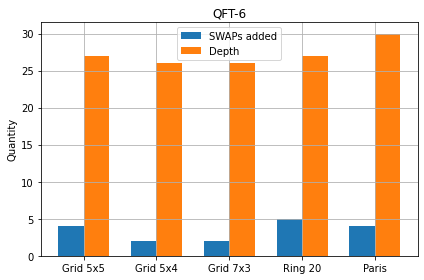

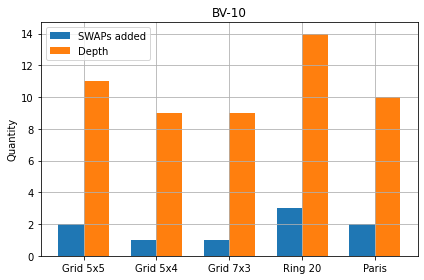

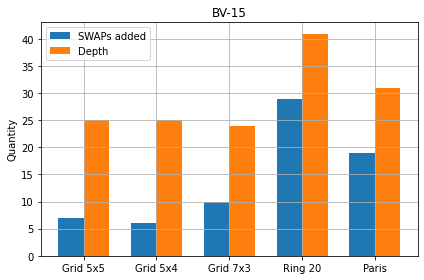

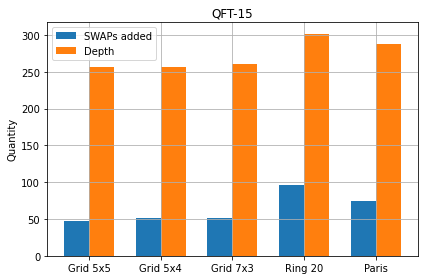

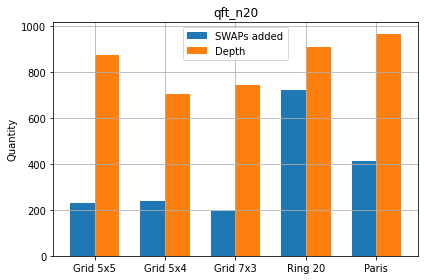

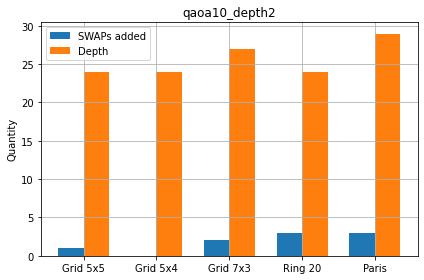

In [91]:
# get our benchmark circuits (not decomposed)
benchmark_dict = get_benchmark_dict(path='./SWAP_Benchmarks')
# decompose our benchmark circuits
benchmark_dict = decompose_benchmarks(benchmark_dict)
# Initialize our coupling maps to be tested on
coupling_dict = create_coupling_maps()

# We pull the results from a file, output of the GA
#my_model = execute_ga(benchmark_dict, coupling_dict)
my_model, depths = load_file('opt2_results.lookahead', get_depth=True)
plot_model(my_model, depths, 'SWAPs added', 'Depth')

#### Now, we do a direct comparison for the number of SWAPS added between the SABRE model and my own model (lower is better).

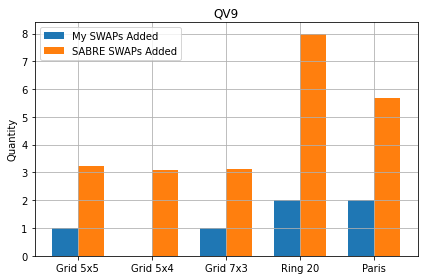

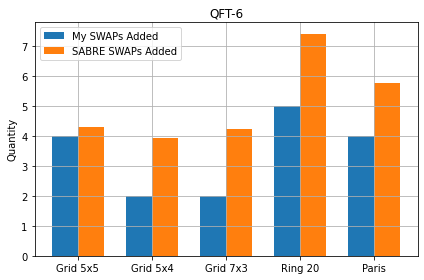

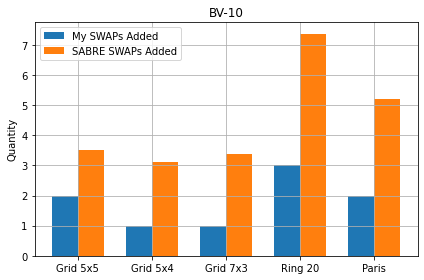

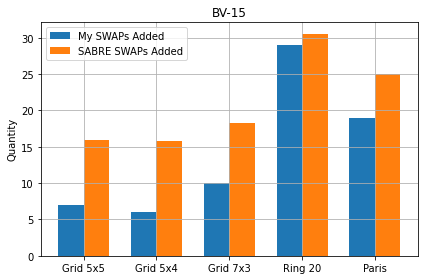

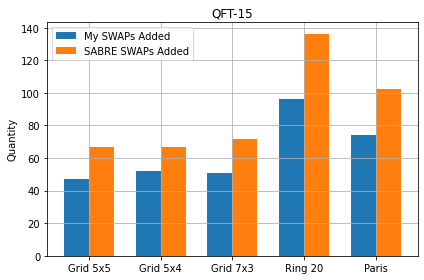

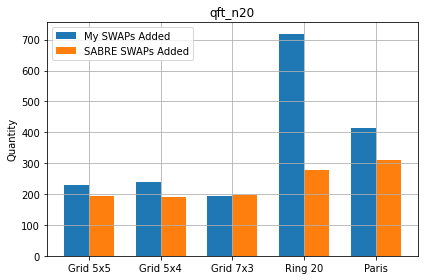

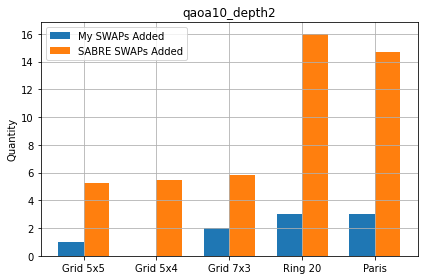

In [92]:
map_names = ['Grid 5x5','Grid 5x4','Grid 7x3','Ring 20','Paris']
qc_names = ['QV9','QFT-6','BV-10','BV-15','QFT-15','qft_n20','qaoa10_depth2']
for qc_name in qc_names:
    sabre_map_dict = sabre_model[qc_name]
    my_map_dict = my_model[qc_name]
    all_sabre_swaps = []
    all_my_swaps = []
    for sabre_map, my_map in zip(sabre_map_dict, my_map_dict):
        all_sabre_swaps.append(sabre_map_dict[sabre_map])
        all_my_swaps.append(my_map_dict[my_map])
    plot_circuit(qc_name, map_names, all_my_swaps, 'My SWAPs Added', 'SABRE SWAPs Added', all_sabre_swaps)

## Question 4

#### Here, we benchmark the baseline SABRE. 
#### NOTE: This takes a while to execute, run the code block below this one to load the results from a file instead.

/Users/brandon/.local/lib/python3.8/site-packages/qiskit/providers/aer/noise/noise_model.py:435: DeprecationWarning: This function is deprecated and will be removed in a future release. To use an X90 based noise model use the Sqrt(X) "sx" gate and one of  the single-qubit phase gates "u1", "rx", "p" in the noise model and  basis gates to decompose into this gateset for noise simulations.
  warn('This function is deprecated and will be removed in a future release. '


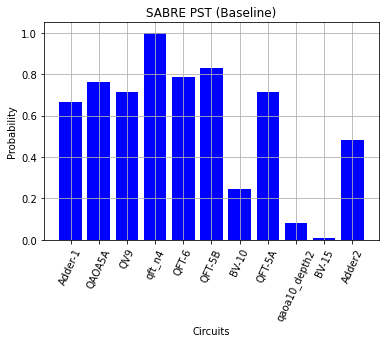

In [24]:
def normalize(input_dict):
    if sum(input_dict.values()) == 0:
        print('Error')    
    factor=1.0/sum(input_dict.values())
    for k in input_dict:
        input_dict[k] = input_dict[k]*factor
    return input_dict 

def pst(in_dict, answer):
    input_dict = in_dict.copy()
    norm_dict = normalize(input_dict)
    output = 0
    for elem in answer:
        if elem in norm_dict:
            output += norm_dict[elem]
    return output

# get our benchmark circuits (not decomposed)
benchmark_dict = get_benchmark_dict(path='./Noise_Benchmarks')
# decompose our benchmark circuits
#benchmark_dict = decompose_benchmarks(benchmark_dict)

noise = pickle.load(open("./Noise-Configs/Paris_Config.pkl", "rb"))
Q_noise = NoiseModel.from_dict(noise)
coupling_map = FakeParis().configuration().coupling_map
basis_gates = Q_noise.basis_gates
import matplotlib.pyplot as plt

iteration = 10

for qc_name in benchmark_dict:
    qc = benchmark_dict[qc_name]
    all_pst = []
    for _ in range(iteration):
        new_qc = transpile(qc, coupling_map=coupling_map,
                           routing_method='sabre', layout_method='sabre')
        # noisy simulation
        result = execute(new_qc, Aer.get_backend('qasm_simulator'),
                         coupling_map=coupling_map,
                         basis_gates=basis_gates,
                         noise_model=Q_noise).result()
        noisy_count = result.get_counts()
        # ideal simulation
        result = execute(new_qc, Aer.get_backend('qasm_simulator'),
                         coupling_map=coupling_map,
                         basis_gates=None,
                         noise_model=None).result()
        ideal_count = result.get_counts()
        all_pst.append(pst(noisy_count, ideal_count.keys()))
    print(qc_name+'     '+str(sum(all_pst)/len(all_pst)))
    plt.bar(qc_name, sum(all_pst)/len(all_pst), color='b')
plt.xticks(rotation=65)
plt.title('SABRE PST (Baseline)')
plt.xlabel('Circuits')
plt.ylabel('Probability')
plt.grid(True)

#### Now, benchmark both SABRE and my model and plot the results

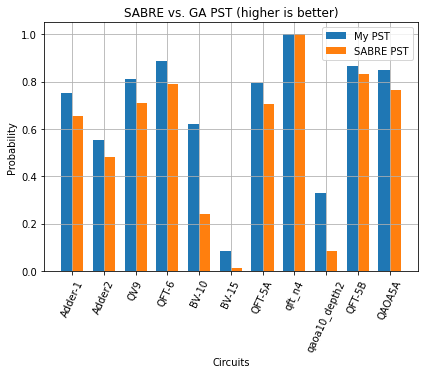

In [93]:
import matplotlib.pyplot as plt
# pull SABRE results from a file instead
f = open('noisy_sabre_results')
names = []
sabre_pst = []
for line in f:
    data = line.split(':')
    names.append(data[0])
    sabre_pst.append(float(data[1]))
f.close()
# pull our results from a file
f = open('noisy_opt1_results')
my_pst = []
for line in f:
    data = line.split(':')
    s = data[1].split()
    my_pst.append(-float(data[2]))
f.close()
plot_circuit('', names, my_pst, 'My PST', 'SABRE PST', sabre_pst) 
plt.xticks(rotation=65)
plt.title('SABRE vs. GA PST (higher is better)')
plt.xlabel('Circuits')
plt.ylabel('Probability')
plt.grid(True)

## Genetic Algorithm - Optimizing SWAPS (Question 3)

In [74]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import U3Gate, U2Gate, U1Gate, CXGate, SwapGate
import numpy as np
from qiskit.compiler import transpile
from qiskit.transpiler import CouplingMap
from qiskit.test.mock import FakeParis
import time
import os
import shutil

def driver():
    # get our benchmark circuits (not decomposed)
    benchmark_dict = get_benchmark_dict(path='../Assignment-3/SWAP_Benchmarks')
    # decompose our benchmark circuits
    benchmark_dict = decompose_benchmarks(benchmark_dict)
    # get all coupling maps
    coupling_dict = create_coupling_maps()
    for qc_name, qc in benchmark_dict.items():
        if qc_name != 'qft_n20':
            continue
        print(qc_name)
        for map_name, coupling_map in coupling_dict.items():
            if map_name != 'paris' and map_name != 'ring_20':
                continue
            width = qc.num_qubits
            # file IO
            f = open(map_name,'a+')
            f.close()
            population = []
            fitness = []
            count = 1
            time_start = time.time()
            timeout = 60*60*6
            while time.time() < time_start+timeout:
                population = breed(population, fitness, width, map_name)
                fitness = eval_circuit(qc, coupling_map, population, 1)
                print('Run '+str(count))
                print_best(population, fitness, map_name)
                count += 1
            # move file over
            shutil.move(map_name, 'log/'+qc_name+'/'+map_name)

def breed(population, fitness, width, map_name):
    # init our population at the start
    if not population and os.path.isfile('seeds.ring_20'):
        print('Loading from '+map_name+'...')
        if map_name == 'ring_20':
            pop, fit = load_best('seeds.ring_20')
        else:
            pop, fit = load_best('seeds.paris')
        fitness = list(set(fit))
        population = [pop[fit.index(f)] for f in fitness]
        for _ in range(len(population), 40):
            layout = np.random.choice(width, width, replace=False)
            population.append(layout)
        return population
    elif not population and not os.path.isfile('seeds'):
        for _ in range(40):
            layout = np.random.choice(width, width, replace=False)
            population.append(layout)
        return population
    # cross breed
    else:
        ind_size = len(population[0])
        if ind_size%2 == 0:
            divisor1 = divisor2 = int(ind_size/2)
        else:
            divisor1 = divisor2 = int((ind_size+1)/2)
        best_indices = np.argsort(np.array(fitness))[:20]
        parents = [population[n] for n in best_indices]
        children = []
        for n in range(0,20,2):
            parent1 = parents[n]
            parent2 = parents[n+1]
            chrom11, chrom12 = list(parent1[:divisor1]), list(parent1[divisor2:])
            chrom21, chrom22 = list(parent2[:divisor1]), list(parent2[divisor2:])
            after_11 = []
            before_12 = []
            after_21 = []
            before_22 = []
            for gene1, gene2 in zip(parent1, parent2):
                if gene2 in chrom12:
                    after_11.append(gene2)
                if gene2 in chrom11:
                    before_12.append(gene2)
                if gene1 in chrom22:
                    after_21.append(gene1)
                if gene1 in chrom21:
                    before_22.append(gene1)
            chrom11 += after_11
            chrom12 = before_12 + chrom12
            chrom21 += after_21
            chrom22 = before_22 + chrom22
            for child in [chrom11, chrom12, chrom21, chrom22]:
                children.append(child)
        # random mutation (~2% probability)
        sel = np.random.choice(40, 1, replace=False)[0]
        if sel < 20:
            unlucky_child = children[sel]
            mutation = np.random.choice(len(chrom11), 4, replace=False)
            for m in range(0,4,2):
                m1, m2 = mutation[m], mutation[m+1]
                unlucky_child[m1], unlucky_child[m2] = unlucky_child[m2], unlucky_child[m1]
        return children

def eval_circuit(qc, coupling_map, population, iteration):
    fitness = []
    for layout in population:
        meas_gates = qc.num_qubits
        before_gates = qc.size() - meas_gates
        before_trans = qc.num_nonlocal_gates()
        swaps = []
        depths = []
        for _ in range(iteration):
            try:
                new_qc = transpile(qc, coupling_map=coupling_map, optimization_level=0, 
                                routing_method='lookahead', initial_layout=layout)
            except:
                new_qc = transpile(qc, coupling_map=coupling_map, optimization_level=0, 
                                routing_method='basic', initial_layout=layout)
            swaps.append(new_qc.num_nonlocal_gates()-before_trans)
            depths.append(new_qc.depth())
        swap_avg = round(sum(swaps)/len(swaps),2)
        fitness.append(swap_avg)
    return fitness

def print_best(population, fitness, map_name):
    # update our best individuals
    top10_indices = np.argsort(np.array(fitness))[:10]
    best_layouts, best_fitness = load_best(map_name)
    if not best_layouts:
        best_layouts = [population[n] for n in top10_indices]
        best_fitness = [fitness[n] for n in top10_indices]
    else:
        for index in top10_indices:
            ind = population[index]
            fit = fitness[index]
            worst_best = max(best_fitness)
            if fit < worst_best:
                new_index = best_fitness.index(worst_best)
                best_fitness[new_index] = fit
                best_layouts[new_index] = ind
    # write to file
    f = open(map_name,'w')
    for ind, fit, in zip(best_layouts, best_fitness):
        string = ''
        for n in range(len(ind)):
            if n == len(ind)-1:
                string = string+str(ind[n])
            else:
                string = string+str(ind[n])+','
        f.write(string+'   =   '+str(fit)+'\n')
    f.close()
    
def load_best(map_name):
    f = open(map_name,'r')
    best_layouts = []
    best_fitness = []
    for line in f:
        string = line.split('=')
        best_layouts.append([int(s) for s in string[0].strip().split(',')])
        best_fitness.append(float(string[1].strip()))
    f.close()
    return best_layouts, best_fitness

def create_coupling_maps():
    coupling_dict = {}
    coupling_dict['grid_5x5'] = CouplingMap.from_grid(5,5)
    coupling_dict['grid_5x4'] = CouplingMap.from_grid(5,4)
    coupling_dict['grid_7x3'] = CouplingMap.from_grid(7,3)
    coupling_dict['ring_20'] = CouplingMap.from_ring(20)
    coupling_dict['paris'] = CouplingMap(FakeParis().configuration().coupling_map)
    return coupling_dict

def get_benchmark_dict(path):
    import glob
    list_qasm = glob.glob(path+'/*.qasm')
    circuit_dict = {}
    for qasm_file in list_qasm:
        circuit_name = qasm_file.split('.qasm')[0].split('Benchmarks/')[1]
        circuit = QuantumCircuit.from_qasm_file(qasm_file)
        circuit.name = circuit_name
        circuit_dict[circuit_name] = circuit
    return circuit_dict

def decompose_benchmarks(benchmark_dict):
    new_dict = {}
    for circuit_name, circuit in benchmark_dict.items():
        new_dict[circuit_name] = transpile(circuit, basis_gates=['cx','u1','u2','u3'])
    return new_dict

## Genetic Algorithm - Optimizing PST (Question 4)
#### The only change for this GA compared to the last one is the fitness function, which uses SABRE for routing and the PST as the designated fitness value for each individual, instead of the number of inserted SWAP's.

In [ ]:
def eval_circuit(qc, coupling_map, population, iteration, basis_gates, Q_noise):
    fitness = []
    for layout in population:
        avg = []
        for _ in range(iteration):
            new_qc = transpile(qc, coupling_map=coupling_map, optimization_level=0,
                            backend=None, basis_gates=None,
                            routing_method='sabre', initial_layout=layout)
            # noisy sim
            result = execute(new_qc, Aer.get_backend('qasm_simulator'),
                            coupling_map=coupling_map, basis_gates=basis_gates,
                            noise_model=Q_noise).result()
            noisy_count = result.get_counts()
            # ideal sim
            result = execute(new_qc, Aer.get_backend('qasm_simulator'),
                            coupling_map=coupling_map, basis_gates=None,
                            noise_model=None).result()
            ideal_count = result.get_counts()
            avg.append(-pst(noisy_count, ideal_count.keys())
        fitness.append(sum(avg)/len(avg))
    return fitness

def pst(in_dict, answer):
    input_dict = in_dict.copy()
    norm_dict = normalize(input_dict)
    output = 0
    for elem in answer:
        if elem in norm_dict:
            output += norm_dict[elem]
    return output

def normalize(input_dict):
    if sum(input_dict.values()) == 0:
        print('none')
    factor = 1.0/sum(input_dict.values())
    for k in input_dict:
        input_dict[k] = input_dict[k]*factor
    return input_dict